# one-hot编码的实现

In [9]:
#导入用于对象保存的与加载的joblib
import joblib

In [10]:
#导入keras中的词汇映射器Tokenizer
from keras.preprocessing.text import Tokenizer

In [11]:
vocab = {"周杰伦", "陈奕迅", "王力宏", "李宗盛", "吴亦凡", "鹿晗"}

In [12]:
#实例化词汇映射器，num_word=None默认处理所有单词
t = Tokenizer(num_words=None, char_level=False)

In [13]:
#使用词汇映射器拟合现有的文本数据
t.fit_on_texts(vocab)

In [15]:
#循环遍历词汇表，映射每个单词
for token in vocab:
    #设置词向量的长度
    zero_list = [0]*len(vocab)
    #使用映射器转化文本数据，每个词汇对应从1开始
    token_indx = t.texts_to_sequences([token])[0][0]-1
    #将词向量的对应位置的索引值设置为1
    zero_list[token_indx] = 1
    print(token, '的one-hot编码为： ', zero_list)

tokenizer_path = './Tokenizer'
joblib.dump(t, tokenizer_path)

吴亦凡 的one-hot编码为：  [1, 0, 0, 0, 0, 0]
李宗盛 的one-hot编码为：  [0, 1, 0, 0, 0, 0]
周杰伦 的one-hot编码为：  [0, 0, 1, 0, 0, 0]
王力宏 的one-hot编码为：  [0, 0, 0, 1, 0, 0]
陈奕迅 的one-hot编码为：  [0, 0, 0, 0, 1, 0]
鹿晗 的one-hot编码为：  [0, 0, 0, 0, 0, 1]


['./Tokenizer']

In [18]:
t = joblib.load('./Tokenizer')
token = '李宗盛'
token_index = t.texts_to_sequences([token])[0][0] -1
zero_list = [0]*6
zero_list[token_index] = 1
print(token,'的one-hot是：',zero_list)

李宗盛 的one-hot是： [0, 1, 0, 0, 0, 0]


# 什么是word2vec

是一种流行的将词汇表示成向量的无监督训练方法, 该过程将构建神经网络模型,
将网络参数作为词汇的向量表示, 它包含CBOW和skipgram两种训练模式.

In [1]:
import numpy as np

In [2]:
from collections import defaultdict

In [58]:
class word2vec():
    def __init__(self):
        self.n = setting['n']
        self.lr = setting['learning_rate']
        self.epochs = setting['epochs']
        self.window = setting['window_size']
        
    def generate_training_data(self, setting, corpus):
        '''得到训练数据'''
        
        #一个字典，当访问的键不存在时，用int类型实例化一个默认值
        word_counts = defaultdict(int)
        
        #遍历语料库corpus
        for row in corpus:
            for word in row:
                #统计每个单词的出现次数
                word_counts[word] += 1
        
        #词汇表的长度       
        self.v_count = len(word_counts.keys())
        #在词汇表中的单词组成的列表
        self.words_list = list(word_counts.keys())
        #以词汇表中单词为key，索引为value的字典数据
        self.word_index = dict((word, i) for i, word in enumerate(self.words_list))
        #以索引为key，以词汇表中的单词为字典数据
        self.index_word = dict((i, word) for i, word in enumerate(self.words_list))
        
        train_data = []
        
        for sentence in corpus:
            sent_len = len(sentence)
            
            for i, word in enumerate(sentence):
            
                w_target = self.word2onehot(sentence[i])
            
                w_context = []
            
            for j in range(i - self.window, i+self.window):
                if j != i and j <= sent_len - 1 and j >= 0:
                    w_context.append(self.word2onehot(sentence[j]))
            
            train_data.append([w_target, w_context])
        
        return np.array(train_data)
    
    def word2onehot(self, word):
        #将单词用one-hot编码
        
        word_vec = [0 for i in range(0, self.v_count)]
        #获取单词的在字典中的索引值
        word_index = self.word_index[word]
        #将onehot编码中该位置的值设置为1
        word_vec[word_index] = 1
        return word_vec
    
    def train(self, train_data):
        
        #随机参数化w1,w2
        self.w1 = np.random.uniform(-1, 1, (self.v_count, self.n))
        
        self.w2 = np.random.uniform(-1, 1, (self.n, self.v_count))
        
        for i in range(self.epochs):
            self.loss = 0
            # w_t 是表示目标词的one-hot向量
            #w_t -> w_target,w_c ->w_context
            for w_t, w_c in train_data:
                #前向传播
                y_pred, h, u = self.forward(w_t)
                
                #计算误差
                EI = np.sum([np.subtract(y_pred, word) for word in w_c], axis=0)
                
                #反向传播，更新参数
                self.backprop(EI, h, w_t)

                #计算总损失
                self.loss += -np.sum([u[word.index(1)] for word in w_c]) + len(w_c) * np.log(np.sum(np.exp(u)))
                
            print('Epoch: ',i, 'loss:', self.loss)
            
    def forward(self, x):
        """
        前向传播
        """
 
        h = np.dot(self.w1.T, x)
 
        u = np.dot(self.w2.T, h)
 
        y_c = self.softmax(u)
 
        return y_c, h, u
    
    def softmax(self, x):
        """
        """
        e_x = np.exp(x - np.max(x))
 
        return e_x / np.sum(e_x)

    def backprop(self, e, h, x):
 
        d1_dw2 = np.outer(h, e)
        d1_dw1 = np.outer(x, np.dot(self.w2, e.T))
 
        self.w1 = self.w1 - (self.lr * d1_dw1)
        self.w2 = self.w2 - (self.lr * d1_dw2)
    
    def word_vec(self, word):
 
        """
        获取词向量
        通过获取词的索引直接在权重向量中找
        """
 
        w_index = self.word_index[word]
        v_w = self.w1[w_index]
 
        return v_w

    def vec_sim(self, word, top_n):
        """
        找相似的词
        """
 
        v_w1 = self.word_vec(word)
        word_sim = {}
 
        for i in range(self.v_count):
            v_w2 = self.w1[i]
            theta_sum = np.dot(v_w1, v_w2)
 
            #np.linalg.norm(v_w1) 求范数 默认为2范数，即平方和的二次开方
            theta_den = np.linalg.norm(v_w1) * np.linalg.norm(v_w2)
            theta = theta_sum / theta_den
 
            word = self.index_word[i]
            word_sim[word] = theta
 
        words_sorted = sorted(word_sim.items(), key=lambda kv: kv[1], reverse=True)
 
        for word, sim in words_sorted[:top_n]:
            print(word, sim)
 
    def get_w(self):
        w1 = self.w1
        return  w1

In [59]:
#数据准备
text = "natural language processing and machine learning is fun and exciting"

In [60]:
import jieba

In [61]:
corpus = jieba.lcut(text)

In [62]:
corpus.remove(' ')

In [63]:
for corpu in corpus:
    if corpu == ' ':
        corpus.remove(corpu)

In [64]:
corpus

['natural',
 'language',
 'processing',
 'and',
 'machine',
 'learning',
 'is',
 'fun',
 'and',
 'exciting']

In [65]:
#超参数
setting = {
    'window_size': 2,   #窗口尺寸 m
    #单词嵌入(word embedding)的维度,维度也是隐藏层的大小。
    'n': 10,
    'epochs': 50,         #表示遍历整个样本的次数。在每个epoch中，我们循环通过一遍训练集的样本。
    'learning_rate':0.01 #学习率
}

In [66]:
#初始化一个Word2vec对象
w2v = word2vec()

In [67]:
train_data = w2v.generate_training_data(setting, corpus)

C:\Users\HP\AppData\Local\Temp\ipykernel_14120\1380975523.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(train_data)


In [68]:
#训练
w2v.train(train_data)

Epoch:  0 loss: 65.28186179067046
Epoch:  1 loss: 62.49333835626412
Epoch:  2 loss: 59.95709553684452
Epoch:  3 loss: 57.63565412785316
Epoch:  4 loss: 55.498082361473365
Epoch:  5 loss: 53.518648662126864
Epoch:  6 loss: 51.67580903485525
Epoch:  7 loss: 49.95146176276482
Epoch:  8 loss: 48.33041115943818
Epoch:  9 loss: 46.79998751999064
Epoch:  10 loss: 45.34977429919802
Epoch:  11 loss: 43.97139844728465
Epoch:  12 loss: 42.658347017461686
Epoch:  13 loss: 41.40578233532541
Epoch:  14 loss: 40.210337981378395
Epoch:  15 loss: 39.06988731181349
Epoch:  16 loss: 37.98328443798145
Epoch:  17 loss: 36.95008428468836
Epoch:  18 loss: 35.97025367571422
Epoch:  19 loss: 35.04388945515912
Epoch:  20 loss: 34.170962218311935
Epoch:  21 loss: 33.35110464793235
Epoch:  22 loss: 32.58346091791102
Epoch:  23 loss: 31.866607721561916
Epoch:  24 loss: 31.198548774853705
Epoch:  25 loss: 30.576774866701072
Epoch:  26 loss: 29.998373095746654
Epoch:  27 loss: 29.46016399736382
Epoch:  28 loss: 28.9

In [79]:
#获取词的向量
word = 'machine'
vec = w2v.word_vec(word)
print(word, vec)

KeyError: 'machine'

## word2vce的简单实现-SkipGram模型

In [105]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.utils.data as data
%matplotlib inline

In [106]:
dtype = torch.FloatTensor
dtype

torch.FloatTensor

## 文本预处理

In [107]:
sentences = ["jack like dog", "jack like cat", "jack like animal",
  "dog cat animal", "banana apple cat dog like", "dog fish milk like",
  "dog cat animal like", "jack like apple", "apple like", "jack like banana",
  "apple banana jack movie book music like", "cat dog hate", "cat dog like"]

In [108]:
#''.join(sentence)将句子中的所有字符以空格连接起来
word_sequence = ' '.join(sentences).split()
#去除重复单词并放入列表
vocab = list(set(word_sequence))
#转为索引与单词对应的字典
word2idx = {w: i for i, w in enumerate(vocab)}

In [109]:
word2idx

{'banana': 0,
 'like': 1,
 'dog': 2,
 'apple': 3,
 'milk': 4,
 'fish': 5,
 'music': 6,
 'animal': 7,
 'hate': 8,
 'jack': 9,
 'movie': 10,
 'book': 11,
 'cat': 12}

## 模型相关参数设置

In [110]:
batch_size = 8
#2 dim vector represent one word
embedding_size = 2 
#window size
C = 2
#词表长度
voc_size = len(vocab)

## 数据预处理

In [111]:
#1
skip_grams = []
for idx in range(C, len(word_sequence) - C):
    #center word 获取中心词的数值表示
    center = word2idx[word_sequence[idx]]
    #中心词的左右范围内词
    context_idx = list(range(idx - C, idx)) + list(range(idx + 1, idx + C + 1))
    #左右四个词的数值表示
    context = [word2idx[word_sequence[i]] for i in context_idx]
    #将中心词的数值与左右四个词的数值分别组对
    for w in context:
        skip_grams.append([center, w])
#2
def make_data(skip_grams):
    input_data = []
    output_data = []
    for i in range(len(skip_grams)):
        #获取中心词对应的独热编码
        input_data.append(np.eye(voc_size)[skip_grams[i][0]])
        #中心对应的上下文词的数值，作为与中心词配对的标签
        output_data.append(skip_grams[i][1])
    return input_data, output_data
#3
input_data, output_data =make_data(skip_grams)
input_data, output_data = torch.Tensor(input_data), torch.LongTensor(output_data)
#将输入与输出装入datatset
dataset = data.TensorDataset(input_data, output_data)
loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

## 构建模型

In [112]:
class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec, self).__init__()
        
        
#         torch.nn.Parameter是继承自torch.Tensor的子类，其主要作用是作为nn.Module中的可训练参数使用。
#         它与torch.Tensor的区别就是nn.Parameter会自动被认为是module的可训练参数，
#         即加入到parameter()这个迭代器中去；
#         而module中非nn.Parameter()的普通tensor是不在parameter中的。
#         nn.Parameter的对象的requires_grad属性的默认值是True，即是可被训练的，
#        这与torth.Tensor对象的默认值相反
        
        #与self-attention中的自乘矩阵类似，是可变的，会根据梯度下降不断调整
        #中间矩阵W，V
        self.W = nn.Parameter(torch.randn(voc_size, embedding_size).type(dtype))
        self.V = nn.Parameter(torch.randn(embedding_size, voc_size).type(dtype))
        
    def forward(self, X):
        #X:[batch_size, voc_size] ont-hot
        # torch.mm only for 2 dim matrix, but torch.matmul can use to any dim
        
        hidden_layer = torch.matmul(X, self.W) # hidden_layer : [batch_size, embedding_size]
        output_layer = torch.matmul(hidden_layer, self.V) # output_layer : [batch_size, voc_size]
        return output_layer
        

In [113]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
model = Word2Vec()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 训练模型

In [114]:
epochs = 2000
for epoch in range(epochs):
    for i, (batch_x, batch_y) in enumerate(loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        
        if (epoch + 1) % 1000 == 0:
            print(epoch + 1, i, loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

1000 0 1.8375694751739502
1000 1 1.738577961921692
1000 2 1.8467507362365723
1000 3 2.8312172889709473
1000 4 2.6680169105529785
1000 5 1.8381412029266357
1000 6 1.7617523670196533
1000 7 1.8250060081481934
1000 8 2.051676034927368
1000 9 2.2264623641967773
1000 10 1.8403165340423584
1000 11 1.8901629447937012
1000 12 2.1053130626678467
1000 13 2.0844287872314453
1000 14 2.266641139984131
1000 15 1.8731367588043213
1000 16 2.3490219116210938
1000 17 2.173323392868042
1000 18 2.5230770111083984
1000 19 1.9397269487380981
1000 20 2.0467922687530518
2000 0 1.7716821432113647
2000 1 2.0466668605804443
2000 2 2.414527654647827
2000 3 1.980623483657837
2000 4 1.8269540071487427
2000 5 1.860558271408081
2000 6 2.006382703781128
2000 7 1.96543550491333
2000 8 1.9728012084960938
2000 9 1.9555045366287231
2000 10 2.1772289276123047
2000 11 2.2595701217651367
2000 12 2.3065390586853027
2000 13 2.077195405960083
2000 14 2.2358155250549316
2000 15 1.829107403755188
2000 16 2.205472469329834
2000 17

由于我这里每个词是用的 2 维的向量去表示，所以可以将每个词在平面直角坐标系中标记出来，看看各个词之间的距离

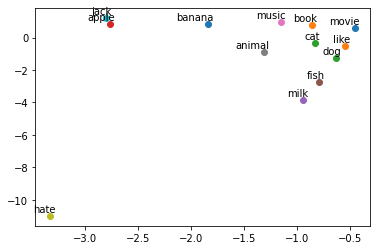

In [116]:
for i, label in enumerate(vocab):
    W, WT = model.parameters()
    x, y = float(W[i][0]), float(W[i][1])
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext = (5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()

# word2vce的简单实现-CBOW模型

In [7]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
dtype = torch.FloatTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 文本预处理

In [9]:
sentences = ["jack like dog", "jack like cat", "jack like animal",
  "dog cat animal", "banana apple cat dog like", "dog fish milk like",
  "dog cat animal like", "jack like apple", "apple like", "jack like banana",
  "apple banana jack movie book music like", "cat dog hate", "cat dog like"]

word_sequence = " ".join(sentences).split() # ['jack', 'like', 'dog', 'jack', 'like', 'cat', 'animal',...]
vocab = list(set(word_sequence)) # build words vocabulary
word2idx = {w: i for i, w in enumerate(vocab)} # {'jack':0, 'like':1,...}

## 模型相关参数

In [10]:
# Word2Vec Parameters
batch_size = 8
embedding_size = 2  # 2 dim vector represent one word
C = 2 # window size
voc_size = len(vocab)

## 数据预处理

In [12]:
#1
cbow = []
for idx in range(C, len(word_sequence) - C):
    center = word2idx[word_sequence[idx]] #中心词数值表示
    context_idx = list(range(idx - C, idx)) + list(range(idx + 1, idx + C +1)) 
    context = [word2idx[word_sequence[i]] for i in context_idx] #上下文4个词的数值表示
    for w in context:
        cbow.append([center, w])

#2
def make_data(cbow):
    input_data = []
    output_data = []
    for i in range(len(cbow)):
        input_data.append(np.eye(voc_size)[cbow[i][1]])
        output_data.append(cbow[i][0])
    return input_data, output_data

#3
input_data, output_data =make_data(cbow)
input_data, output_data =torch.Tensor(input_data), torch.LongTensor(output_data)
dataset = data.TensorDataset(input_data, output_data)
loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_16720\1847691472.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  input_data, output_data =torch.Tensor(input_data), torch.LongTensor(output_data)


## 构建模型

In [13]:
class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec, self).__init__()
        
        self.W = nn.Parameter(torch.randn(voc_size, embedding_size).type(dtype))
        self.V = nn.Parameter(torch.randn(embedding_size, voc_size).type(dtype))
        
    def forward(self, X):
        hidden_layer = torch.matmul(X, self.W)
        output_layer = torch.matmul(hidden_layer, self.V)
        return output_layer

In [16]:
model = Word2Vec().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
epochs = 2000
for epoch in range(epochs):
    for i, (batch_x, batch_y) in enumerate(loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        if (epoch + 1) % 1000 == 0:
            print(epoch + 1, i, loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

1000 0 1.7063379287719727
1000 1 1.8152401447296143
1000 2 2.0010876655578613
1000 3 2.5318408012390137
1000 4 1.914341688156128
1000 5 2.0576062202453613
1000 6 2.050158739089966
1000 7 2.3280375003814697
1000 8 2.379971742630005
1000 9 2.1083903312683105
1000 10 1.8559517860412598
1000 11 2.084395408630371
1000 12 2.870319366455078
1000 13 2.865453004837036
1000 14 2.1126513481140137
1000 15 1.8402706384658813
1000 16 1.7999267578125
1000 17 2.233675003051758
1000 18 2.0503029823303223
1000 19 2.1660823822021484
1000 20 2.1476261615753174
2000 0 1.8594021797180176
2000 1 2.14296555519104
2000 2 2.2795000076293945
2000 3 2.046396017074585
2000 4 2.0789875984191895
2000 5 2.2407827377319336
2000 6 2.213014841079712
2000 7 1.9122023582458496
2000 8 2.4768431186676025
2000 9 2.5083131790161133
2000 10 2.0824339389801025
2000 11 1.9251646995544434
2000 12 1.952661395072937
2000 13 2.0680582523345947
2000 14 1.8110406398773193
2000 15 2.1531565189361572
2000 16 2.1597743034362793
2000 17 1

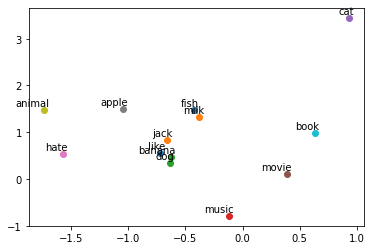

In [18]:
for i, label in enumerate(vocab):
    W, WT = model.parameters()
    x,y = float(W[i][0]), float(W[i][1])
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()

# 使用fasttext工具实现word2vec的训练和使用

## 导入fasttext

In [19]:
# 代码运行在python解释器中
# 导入fasttext
import fasttext

## 训练词向量

In [20]:
# 使用fasttext的train_unsupervised(无监督训练方法)进行词向量的训练
model = fasttext.train_unsupervised('./text8/text8',model='skipgram')

In [23]:
len(model.words)

71290

In [26]:
model['the']

array([ 0.15249524,  0.01019637,  0.5823952 ,  0.29414508, -0.06755973,
        0.3079187 ,  0.1251047 ,  0.19072683, -0.2580842 ,  0.10021532,
       -0.00973318,  0.23842354, -0.16674753,  0.14962053, -0.00394648,
       -0.21846476, -0.09119813,  0.12712152, -0.11043776, -0.12689362,
       -0.03622026,  0.06128269, -0.19585198, -0.03965288,  0.04922216,
       -0.05784786, -0.01834672,  0.1208871 ,  0.2112543 , -0.24600357,
        0.3207355 ,  0.01802887, -0.24890038, -0.22829983, -0.07234905,
        0.21496066,  0.10661756, -0.09323972, -0.21531424, -0.0049559 ,
        0.05546901, -0.05056279,  0.03115782,  0.08663321,  0.29738194,
       -0.10903385, -0.10255983,  0.20946474,  0.21555276,  0.3014551 ,
        0.28866744,  0.18747586, -0.04386143, -0.19789644, -0.26508844,
       -0.08573692,  0.11692691,  0.04947214,  0.1453203 ,  0.0180522 ,
        0.01432479, -0.00597281,  0.09317304,  0.09277564,  0.0416959 ,
       -0.02274245, -0.17256573,  0.148725  ,  0.09897637, -0.09

In [27]:
model.get_word_vector('the')

array([ 0.15249524,  0.01019637,  0.5823952 ,  0.29414508, -0.06755973,
        0.3079187 ,  0.1251047 ,  0.19072683, -0.2580842 ,  0.10021532,
       -0.00973318,  0.23842354, -0.16674753,  0.14962053, -0.00394648,
       -0.21846476, -0.09119813,  0.12712152, -0.11043776, -0.12689362,
       -0.03622026,  0.06128269, -0.19585198, -0.03965288,  0.04922216,
       -0.05784786, -0.01834672,  0.1208871 ,  0.2112543 , -0.24600357,
        0.3207355 ,  0.01802887, -0.24890038, -0.22829983, -0.07234905,
        0.21496066,  0.10661756, -0.09323972, -0.21531424, -0.0049559 ,
        0.05546901, -0.05056279,  0.03115782,  0.08663321,  0.29738194,
       -0.10903385, -0.10255983,  0.20946474,  0.21555276,  0.3014551 ,
        0.28866744,  0.18747586, -0.04386143, -0.19789644, -0.26508844,
       -0.08573692,  0.11692691,  0.04947214,  0.1453203 ,  0.0180522 ,
        0.01432479, -0.00597281,  0.09317304,  0.09277564,  0.0416959 ,
       -0.02274245, -0.17256573,  0.148725  ,  0.09897637, -0.09

## 模型效果检验

In [28]:
model.get_nearest_neighbors('sport')

[(0.8533971309661865, 'sports'),
 (0.8095163702964783, 'sporty'),
 (0.8024839758872986, 'sportsmanship'),
 (0.7584807276725769, 'racquetball'),
 (0.7496558427810669, 'korfball'),
 (0.7435039281845093, 'dancesport'),
 (0.7421703338623047, 'sportsman'),
 (0.7400426268577576, 'motorsport'),
 (0.7388135194778442, 'competitions'),
 (0.7360743284225464, 'soccer')]

In [29]:
model.get_nearest_neighbors('dog')

[(0.7989189624786377, 'foxhound'),
 (0.7860063314437866, 'hound'),
 (0.7602492570877075, 'dogs'),
 (0.7462156414985657, 'wolfhound'),
 (0.7326763272285461, 'hounds'),
 (0.7217750549316406, 'coonhound'),
 (0.7122202515602112, 'horehound'),
 (0.7062540650367737, 'bloodhound'),
 (0.7008688449859619, 'keeshond'),
 (0.6956068277359009, 'hotdog')]

In [30]:
model.get_nearest_neighbors('music')

[(0.8734408617019653, 'musics'),
 (0.8485551476478577, 'musical'),
 (0.8410089015960693, 'allmusic'),
 (0.8095620274543762, 'musicam'),
 (0.7938967943191528, 'musicianship'),
 (0.7889672517776489, 'musica'),
 (0.7860141396522522, 'musicals'),
 (0.7579303979873657, 'dance'),
 (0.7569871544837952, 'dancehall'),
 (0.7540735602378845, 'jazz')]

## 模型的保存与重加载

In [31]:
model.save_model('file9.bin')

In [32]:
model = fasttext.load_model('file9.bin')

In [33]:
model.get_word_vector('the')

array([ 0.15249524,  0.01019637,  0.5823952 ,  0.29414508, -0.06755973,
        0.3079187 ,  0.1251047 ,  0.19072683, -0.2580842 ,  0.10021532,
       -0.00973318,  0.23842354, -0.16674753,  0.14962053, -0.00394648,
       -0.21846476, -0.09119813,  0.12712152, -0.11043776, -0.12689362,
       -0.03622026,  0.06128269, -0.19585198, -0.03965288,  0.04922216,
       -0.05784786, -0.01834672,  0.1208871 ,  0.2112543 , -0.24600357,
        0.3207355 ,  0.01802887, -0.24890038, -0.22829983, -0.07234905,
        0.21496066,  0.10661756, -0.09323972, -0.21531424, -0.0049559 ,
        0.05546901, -0.05056279,  0.03115782,  0.08663321,  0.29738194,
       -0.10903385, -0.10255983,  0.20946474,  0.21555276,  0.3014551 ,
        0.28866744,  0.18747586, -0.04386143, -0.19789644, -0.26508844,
       -0.08573692,  0.11692691,  0.04947214,  0.1453203 ,  0.0180522 ,
        0.01432479, -0.00597281,  0.09317304,  0.09277564,  0.0416959 ,
       -0.02274245, -0.17256573,  0.148725  ,  0.09897637, -0.09